In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import os
import torchtext
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

debug = True

print("Pytorch: \t\t", torch.__version__)
if not debug and torch.cuda.is_available():
    device='cuda'
    print('GPU:         \t\t', torch.cuda.get_device_name(0))
    print('Memory Usage:\t',
        round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB / ',
        round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
    torch.backends.cudnn.benchmark = True
else:
    print("GPU is **not available**")
    device='cpu'

Pytorch: 		 1.10.2+cu102
GPU is **not available**


In [56]:
train_dataset, test_dataset = torchtext.datasets.IMDB(split=('train', 'test'))

In [57]:

from torchtext.data.functional import to_map_style_dataset

train_dataset = to_map_style_dataset(train_dataset)
test_dataset = to_map_style_dataset(test_dataset)

In [58]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [59]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 1 if x == 'pos' else 0

In [60]:
label_pipeline('pos')

1

In [61]:
# Initializing parameters

batch_size = 32     # Reduce this if you get memory errors

seed = 2476          # A random seed to get replicable results

## Avoiding ValueError (using a target size different to the input size)

```ValueError: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.```

Simply add `.unsqueeze(-1)` to the end of your label tensor.



In [85]:
def collate_batch(batch):
     label_list, text_list, offsets = [], [], [0]
     for (_label, _text) in batch:
          label_list.append(label_pipeline(_label))
          processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
          text_list.append(processed_text)
          offsets.append(processed_text.size(0))

     label_list = torch.tensor(label_list, dtype=torch.int64)
     offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
     text_list = torch.cat(text_list)
     
     # print("-----")
     # print(text_list, label_list, offsets)
     # print("-----")
     
     return text_list.to(device), label_list.to(device), offsets.to(device)

In [86]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=collate_batch)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    collate_fn=collate_batch)


In [87]:

for X, y, o in test_dataloader:
    print("Shape of X: ", X.shape)
    print("Labels : ", y.shape)
    print("Offsets: ", o.shape)
    # print(X, y, o)
    break

Shape of X:  torch.Size([7773])
Labels :  torch.Size([32])
Offsets:  torch.Size([32])


In [88]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [93]:
def train_loop(dataloader, model, loss_fn, optimizer, history):
    size = len(dataloader.dataset)
    accuracy, loss = 0, 0
    for batch, (X, y, offs) in enumerate(dataloader):
        
        #FORWARD PASS
        pred = model(X, offs)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        loss = loss.item()
        accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    accuracy /= size
    history['train_loss'].append(loss)
    history['train_accuracy'].append(accuracy)
    return loss, accuracy


def test_loop(dataloader, model, loss_fn, history):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, accuracy = 0, 0

    with torch.no_grad():
        for X, y, offs in dataloader:            
            pred = model(X, offs)
            
            loss += loss_fn(pred, y).item()
            accuracy += (pred == y).type(torch.float).sum().item()

    loss /= num_batches
    accuracy /= size

    history['test_loss'].append(loss)
    history['test_accuracy'].append(accuracy)
    return loss, accuracy

In [94]:
emsize = 64
num_classes = 2
vocab_size = len(vocab)

model = TextClassificationModel(vocab_size, emsize, num_classes).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)


In [95]:
count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {count}")

Number of trainable parameters: 6443842


In [96]:
epochs = 10
history = {
    'train_loss':[],
    'train_accuracy':[],
    'test_loss':[],
    'test_accuracy':[]
}

for t in tqdm(range(epochs), bar_format="{elapsed} Elapsed | {percentage:3.0f}% done |{bar}| {n_fmt}/{total_fmt} [{remaining} remaining | {rate_fmt}{postfix}]", unit="epoch", total=epochs):
    train_loop(train_dataloader, model, loss_fn, optimizer, history)
    test_loop(test_dataloader, model, loss_fn, history)
    scheduler.step()

00:00 Elapsed |   0% done |          | 0/10 [? remaining | ?epoch/s]


RuntimeError: The size of tensor a (2) must match the size of tensor b (32) at non-singleton dimension 1

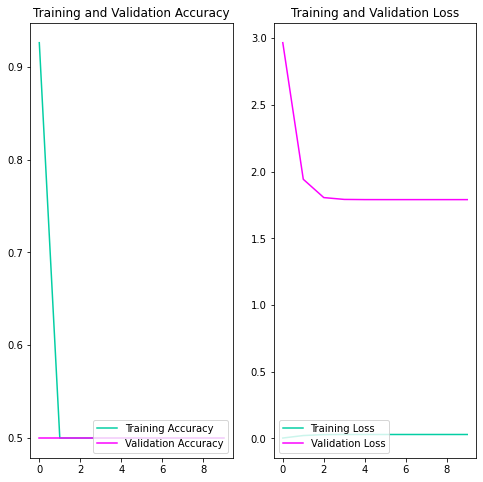

In [71]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_accuracy'], label='Training Accuracy', color='#03CEA4')
plt.plot(epochs_range, history['test_accuracy'], label='Validation Accuracy', color='#fc00ff')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_loss'], label='Training Loss', color='#03CEA4')
plt.plot(epochs_range, history['test_loss'], label='Validation Loss', color='#fc00ff')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()
